# PaddleOCR with OpenVINO

This demo shows how to run PaddleOCR (Lite) model on OpenVINO natively. Instead of exporting the PaddlePaddle model to ONNX and then create the Intermediate Representation (IR) format through OpenVINO optimizer, we can now read direct from the Paddle Model without any conversions.

Authors: 
Zhuo Wu, PhD (OpenVINO Edge AI Software Evangelist - Intel)

## Run Paddle Detection with OpenVINO

In [1]:
import os, os.path
import sys
import json
import urllib.request
import cv2
import numpy as np
import paddle
import math
import time

from openvino.inference_engine import IENetwork, IECore, ExecutableNetwork
from IPython import display
from PIL import Image, ImageDraw
import copy

import logging
import imghdr
from shapely.geometry import Polygon
import pyclipper

from pre_post_processing import *

### Load the image

In [2]:
def image_preprocess(input_image, size):
    img = cv2.resize(input_image, (size,size))
    img = np.transpose(img, [2,0,1]) / 255
    img = np.expand_dims(img, 0)
    ##NormalizeImage: {mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225], is_scale: True}
    img_mean = np.array([0.485, 0.456,0.406]).reshape((3,1,1))
    img_std = np.array([0.229, 0.224, 0.225]).reshape((3,1,1))
    img -= img_mean
    img /= img_std
    return img.astype(np.float32)

In [3]:
# Test images provided include 1 handwritten Chinese image and 1 printed Chinese image
image_file = "handwritten_simplified_chinese_test.jpg"

ii = cv2.imread(image_file)
test_image = image_preprocess(ii,640)

### Load the Network

In [4]:
model_dir = "./inference/ch_ppocr_mobile_v2.0_det_infer"
model_file_path = model_dir + "/inference.pdmodel"
params_file_path = model_dir + "/inference.pdiparams"

In [5]:
# initialize inference engine
ie = IECore()
# initialize inference engine
net = ie.read_network(model_file_path)

# pdmodel might be dynamic shape, this will reshape based on the input
input_key = list(net.input_info.items())[0][0] # 'inputs'
net.reshape({input_key: test_image.shape})

exec_net = ie.load_network(net, 'CPU') 
assert isinstance(exec_net, ExecutableNetwork)

In [6]:
#perform the inference step
det_start_time = time.time()
output = exec_net.infer({input_key: test_image})
det_stop_time = time.time()
result_ie = list(output.values())
det_infer_time = det_stop_time - det_start_time

### Postprocessing the inference result for PaddleDetection

In [7]:
ori_im = ii.copy()
data = {'image': ii}

data_resize = DetResizeForTest(data)
data_norm = NormalizeImage(data_resize)
data_list = []
keep_keys =  ['image', 'shape']
for key in keep_keys:
    data_list.append(data[key])
img, shape_list = data_list

shape_list = np.expand_dims(shape_list, axis=0)
pred = result_ie[0]      
if isinstance(pred, paddle.Tensor):
    pred = pred.numpy()
pred = pred[:, 0, :, :]
segmentation = pred > 0.3

boxes_batch = []
for batch_index in range(pred.shape[0]):
    src_h, src_w, ratio_h, ratio_w = shape_list[batch_index]

    mask = segmentation[batch_index]
    boxes, scores = boxes_from_bitmap(pred[batch_index], mask,src_w, src_h)
    boxes_batch.append({'points': boxes})

post_result = boxes_batch
dt_boxes = post_result[0]['points']
dt_boxes = filter_tag_det_res(dt_boxes, ii.shape)

## Run Paddle Recognition with OpenVINO

In [8]:
# Processing detection results for Recognition
dt_boxes = sorted_boxes(dt_boxes)
img_crop_list = []

for bno in range(len(dt_boxes)):
    tmp_box = copy.deepcopy(dt_boxes[bno])
    img_crop = get_rotate_crop_image(ori_im, tmp_box)
    img_crop_list.append(img_crop)

### Preprocess the Image for Paddle Recognition

In [9]:
def resize_norm_img(img, max_wh_ratio):
        rec_image_shape = [3, 32, 320]
        imgC, imgH, imgW = rec_image_shape
        assert imgC == img.shape[2]
        character_type = "ch"
        if character_type == "ch":
            imgW = int((32 * max_wh_ratio))
        h, w = img.shape[:2]
        ratio = w / float(h)
        if math.ceil(imgH * ratio) > imgW:
            resized_w = imgW
        else:
            resized_w = int(math.ceil(imgH * ratio))
        resized_image = cv2.resize(img, (resized_w, imgH))
        resized_image = resized_image.astype('float32')
        resized_image = resized_image.transpose((2, 0, 1)) / 255
        resized_image -= 0.5
        resized_image /= 0.5
        padding_im = np.zeros((imgC, imgH, imgW), dtype=np.float32)
        padding_im[:, :, 0:resized_w] = resized_image
        return padding_im

### Load the Network

In [10]:
model_dir = "./inference/ch_ppocr_mobile_v2.0_rec_infer"
model_file_path = model_dir + "/inference.pdmodel"
params_file_path = model_dir + "/inference.pdiparams"

ie = IECore()
net = ie.read_network(model_file_path)

### Recognition starts from here

In [11]:
img_num = len(img_crop_list)
# Calculate the aspect ratio of all text bars
width_list = []
for img in img_crop_list:
    width_list.append(img.shape[1] / float(img.shape[0]))
# Sorting can speed up the recognition process
indices = np.argsort(np.array(width_list))
rec_res = [['', 0.0]] * img_num
rec_batch_num = 6
batch_num = rec_batch_num
rec_processing_times = 0

In [12]:
for beg_img_no in range(0, img_num, batch_num):
    end_img_no = min(img_num, beg_img_no + batch_num)
    norm_img_batch = []
    max_wh_ratio = 0
    for ino in range(beg_img_no, end_img_no):
        h, w = img_crop_list[indices[ino]].shape[0:2]
        wh_ratio = w * 1.0 / h
        max_wh_ratio = max(max_wh_ratio, wh_ratio)
    for ino in range(beg_img_no, end_img_no):
        norm_img = resize_norm_img(img_crop_list[indices[ino]],max_wh_ratio)
        norm_img = norm_img[np.newaxis, :]
        norm_img_batch.append(norm_img)

    norm_img_batch = np.concatenate(norm_img_batch)
    norm_img_batch = norm_img_batch.copy()
    
    # pdmodel might be dynamic shape, this will reshape based on the input
    input_key = list(net.input_info.items())[0][0] # 'inputs'
    net.reshape({input_key: norm_img_batch.shape})

    #load the network on CPU
    start_time = time.time()
    exec_net = ie.load_network(net, 'CPU') 
    stop_time = time.time()
    assert isinstance(exec_net, ExecutableNetwork)
    
    rec_processing_times += stop_time - start_time

    for index in range(len(norm_img_batch)):
        output = exec_net.infer({input_key: norm_img_batch})
    result_ie = list(output.values())
    preds = result_ie[0]
    postprocess_op = build_post_process(postprocess_params)
    rec_result = postprocess_op(preds)
    for rno in range(len(rec_result)):
        rec_res[indices[beg_img_no + rno]] = rec_result[rno]

In [13]:
final_stop_time = time.time()
processing_time = final_stop_time - det_start_time
print("The total prediction and processing time is ", processing_time)

The total prediction and processing time is  0.3596353530883789


In [14]:
print("The total inference time for detection is ", det_infer_time)
print("The total inference time for recognition is ", rec_processing_times)

The total inference time for detection is  0.030055999755859375
The total inference time for recognition is  0.127180814743042


### Visulaize detection and recognition results

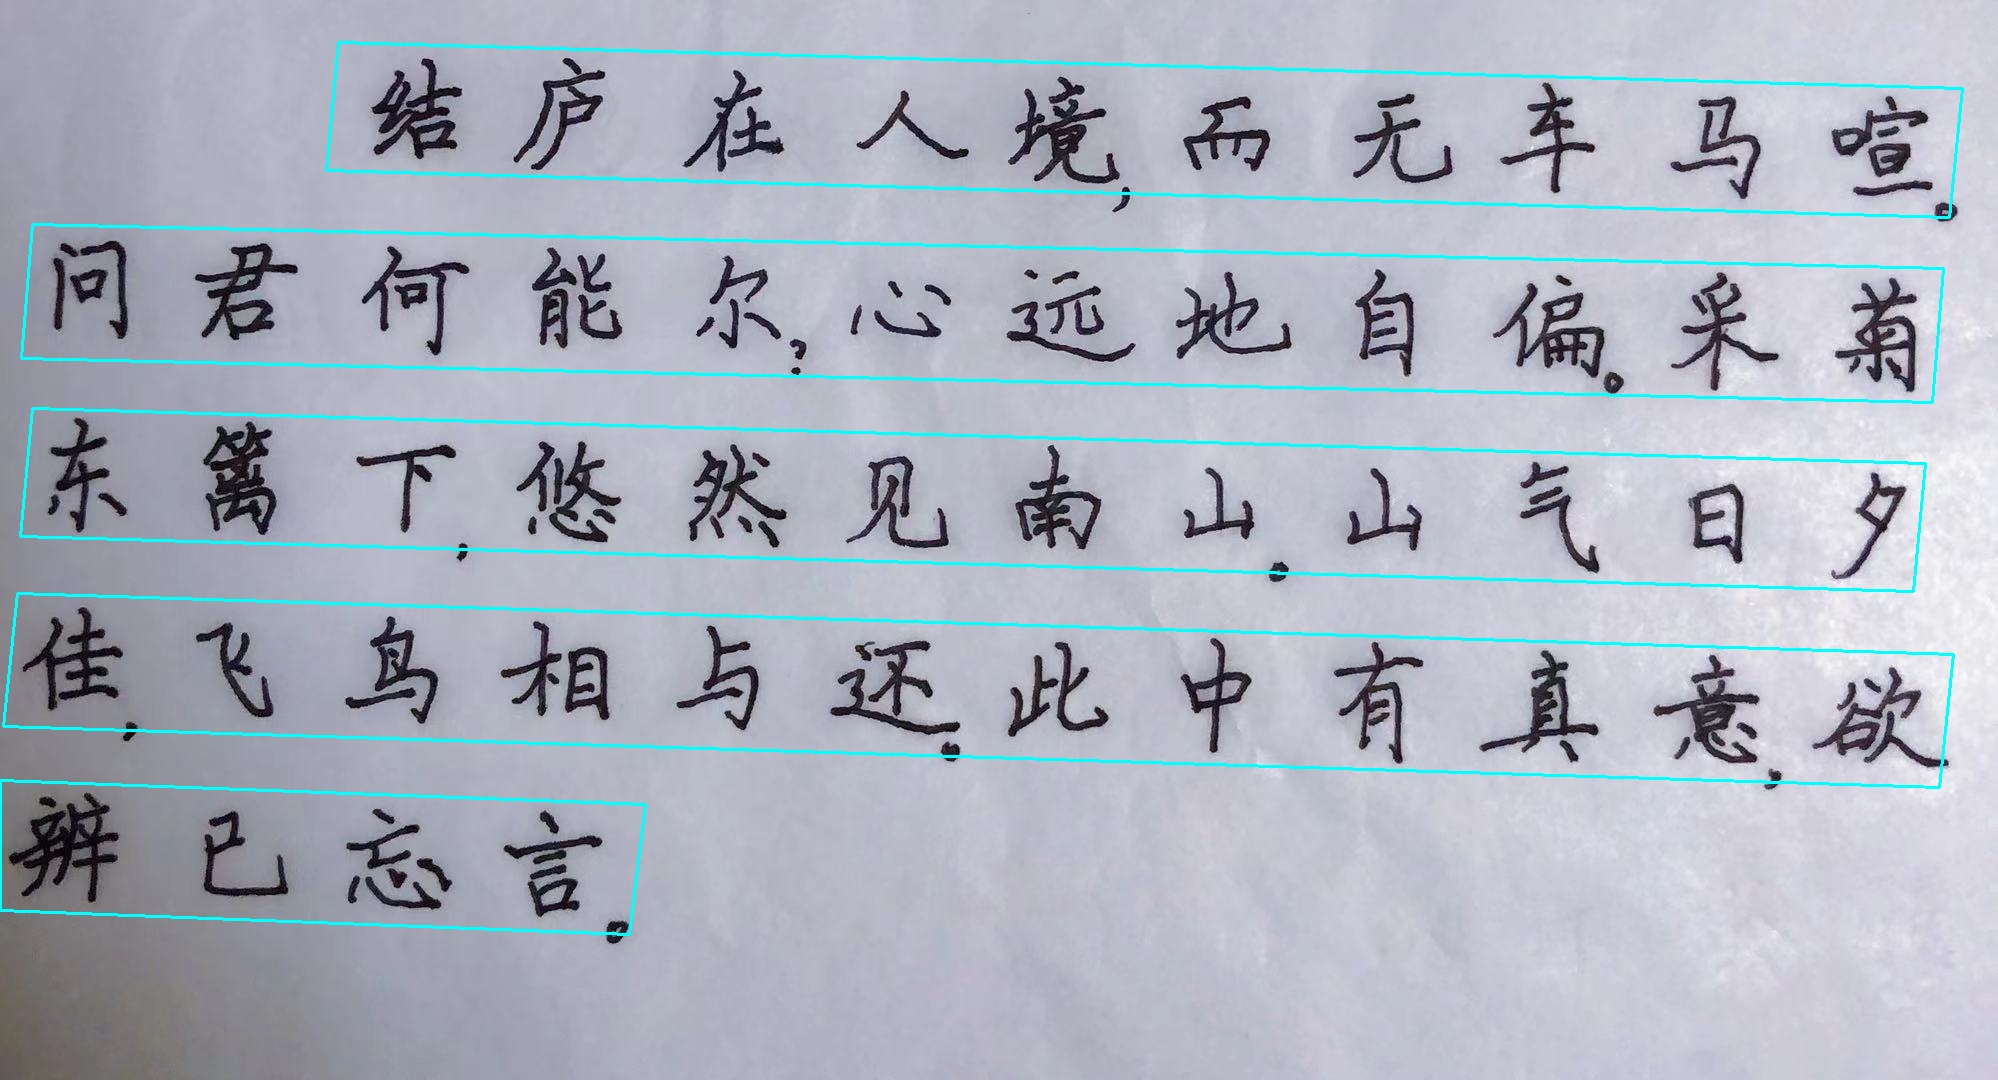

In [15]:
src_im = draw_text_det_res(dt_boxes, image_file)
img_name_pure = os.path.split(image_file)[-1]
img_path = "det_res_{}".format(img_name_pure)
cv2.imwrite(img_path, src_im)

#Visualization Paddle Detection results
_,ret_array = cv2.imencode('.jpg', src_im) 
i = display.Image(data=ret_array)            
display.display(i)

In [16]:
#Visualization Paddle Recognition results, format
print(rec_res)

[('结庐在人境品无车马喧', 0.7947357), ('问君何能尔心远地自偏采前', 0.78279454), ('东鹤下您然见南山山气日夕', 0.8802729), ('佳飞鸟相与还此中有真意欲', 0.8675663), ('辩已意言', 0.38597608)]
